## Phased LSTM 

                           generation biomass  \
time                                            
2014-12-31 23:00:00+00:00               447.0   
2015-01-01 00:00:00+00:00               449.0   
2015-01-01 01:00:00+00:00               448.0   
2015-01-01 02:00:00+00:00               438.0   
2015-01-01 03:00:00+00:00               428.0   
...                                       ...   
2018-12-31 18:00:00+00:00               297.0   
2018-12-31 19:00:00+00:00               296.0   
2018-12-31 20:00:00+00:00               292.0   
2018-12-31 21:00:00+00:00               293.0   
2018-12-31 22:00:00+00:00               290.0   

                           generation fossil brown coal/lignite  \
time                                                              
2014-12-31 23:00:00+00:00                                 329.0   
2015-01-01 00:00:00+00:00                                 328.0   
2015-01-01 01:00:00+00:00                                 323.0   
2015-01-01 02:00:00+00:00  

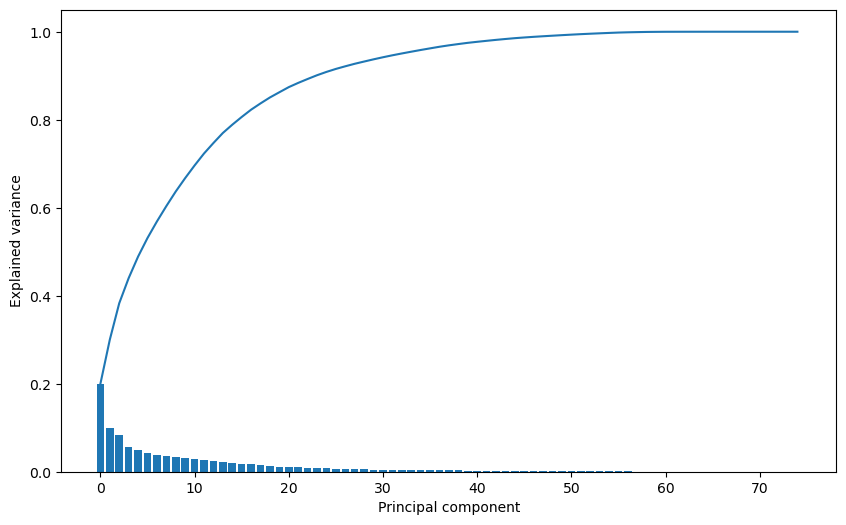

In [1]:

#Standard libraries
import random
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import random

# Pytorch
import torch

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from phased_lstm import PhasedLSTM, PhasedLSTMCell

import import_ipynb
from feature_engineering import scaler_y

In [2]:
# Data Import 

# Load X_train
with open("data/X_train.pkl", "rb") as f:
    X_train = pickle.load(f)

# Load y_train
with open("data/y_train.pkl", "rb") as f:
    y_train = pickle.load(f)

# Load X_val
with open("data/X_val.pkl", "rb") as f:
    X_val = pickle.load(f)

# Load y_val
with open("data/y_val.pkl", "rb") as f:
    y_val = pickle.load(f)

# Load X_test
with open("data/X_test.pkl", "rb") as f:
    X_test = pickle.load(f)

# Load y_test
with open("data/y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

# Load df_final_viz
with open("data/df_final_viz.pkl", "rb") as f:
    df_final_viz = pickle.load(f)


In [3]:
#Seed for reproducibility

SEED  = 42

random.seed(SEED) 
np.random.seed(SEED)
torch.manual_seed(SEED)

In [4]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)  
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)  

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)


In [5]:
X_train_tensor.shape


torch.Size([27024, 24, 17])

In [38]:
USE_GPU = False 

if USE_GPU and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Modell läuft auf: {device}")



# PhasedLSTM 
class PhasedLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=200, dense_units=32, bidirectional=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.bi = 2 if bidirectional else 1
        
        # PhasedLSTM anstelle von Standard-LSTM
        self.phased_lstm = PhasedLSTM(input_size=input_size, hidden_size=hidden_size, bidirectional=bidirectional)
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(self.bi * hidden_size, dense_units)
        self.fc2 = nn.Linear(dense_units, 1)

    def forward(self, x):
        # Input: (batch_size, time_steps, input_size)
        lstm_out = self.phased_lstm(x)  # PhasedLSTM-Ausgabe (batch, timesteps, hidden)
        lstm_out = lstm_out[:, -1, :]   # Letzter Zeitschritt
        out = self.dropout(lstm_out)
        out = self.fc1(out)
        return self.fc2(out)

# Initialisiere Modell
input_size = X_train.shape[2] - 1  # letzter Wert im Input ist Timestamp
model = PhasedLSTMModel(input_size).to(device)

# Loss & Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True)

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            val_outputs = model(X_val_batch).squeeze()
            val_loss += criterion(val_outputs, y_val_batch.squeeze()).item()

    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")





Modell läuft auf: cpu
Epoch 1/10 | Train Loss: 0.0095 | Val Loss: 0.0156
Epoch 2/10 | Train Loss: 0.0062 | Val Loss: 0.0137
Epoch 3/10 | Train Loss: 0.0054 | Val Loss: 0.0132
Epoch 4/10 | Train Loss: 0.0050 | Val Loss: 0.0139
Epoch 5/10 | Train Loss: 0.0045 | Val Loss: 0.0149
Epoch 6/10 | Train Loss: 0.0042 | Val Loss: 0.0131
Epoch 7/10 | Train Loss: 0.0039 | Val Loss: 0.0130
Epoch 8/10 | Train Loss: 0.0037 | Val Loss: 0.0136
Epoch 9/10 | Train Loss: 0.0035 | Val Loss: 0.0134
Epoch 10/10 | Train Loss: 0.0033 | Val Loss: 0.0121


In [43]:
model.eval()
test_loss = 0
test_predictions = []

with torch.no_grad():
    for X_test_batch, y_test_batch in test_loader:
        X_test_batch = X_test_batch.to(device)
        y_test_batch = y_test_batch.to(device)

        test_outputs = model(X_test_batch).squeeze()
        loss = criterion(test_outputs, y_test_batch.squeeze())
        test_loss += loss.item()

        test_predictions.extend(test_outputs.cpu().numpy())

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0004


In [44]:
def RMSELoss(y_pred, y_true):
    return torch.sqrt(torch.mean((y_pred - y_true) ** 2))

RMSE = RMSELoss(torch.tensor(test_predictions), y_test_tensor).item()
print(f"Test RMSE: {RMSE:.4f}")

Test RMSE: 0.0207


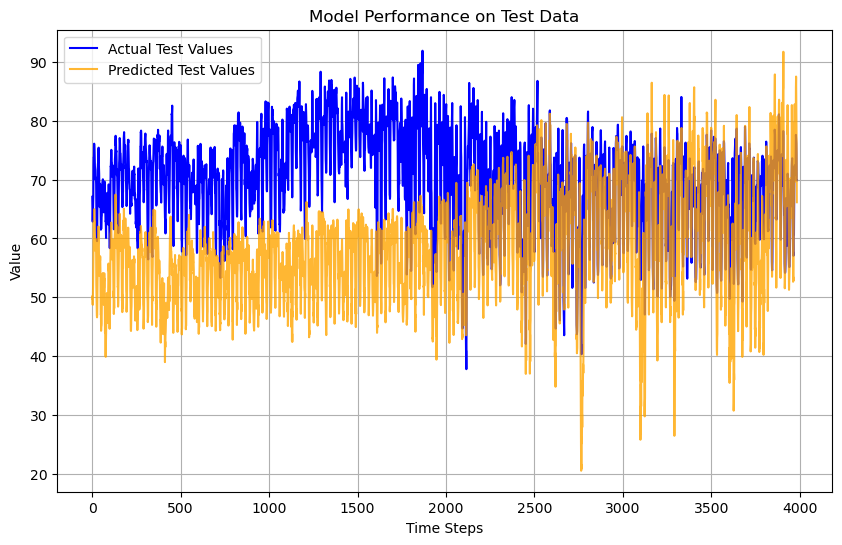

In [39]:
import matplotlib.pyplot as plt
import torch
import numpy as np

model.eval()

with torch.no_grad():
    test_pred = model(X_test_tensor.to(device)).cpu().numpy()

test_pred_inv = scaler_y.inverse_transform(test_pred.reshape(-1, 1))
y_test_inv = scaler_y.inverse_transform(y_test_tensor.cpu().numpy().reshape(-1, 1))

plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual Test Values', color='blue')
plt.plot(test_pred_inv, label='Predicted Test Values', color='orange', alpha=0.8)

plt.title('Model Performance on Test Data')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
USE_GPU = False 

if USE_GPU and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Modell läuft auf: {device}")

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=48, dense_units=32, bidirectional=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.bi = 2 if bidirectional else 1
        
        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size, 
                            batch_first=True,
                            bidirectional=bidirectional)
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(self.bi * hidden_size, dense_units)
        self.fc2 = nn.Linear(dense_units, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  
        out = self.dropout(lstm_out)
        out = self.fc1(out)
        return self.fc2(out)

input_size = X_train.shape[2]
model = LSTMModel(input_size).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True)

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            val_outputs = model(X_val_batch).squeeze()
            val_loss += criterion(val_outputs, y_val_batch.squeeze()).item()

    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

Modell läuft auf: cpu
Epoch 1/10 | Train Loss: 0.0101 | Val Loss: 0.0032
Epoch 2/10 | Train Loss: 0.0019 | Val Loss: 0.0011
Epoch 3/10 | Train Loss: 0.0014 | Val Loss: 0.0007
Epoch 4/10 | Train Loss: 0.0012 | Val Loss: 0.0007
Epoch 5/10 | Train Loss: 0.0010 | Val Loss: 0.0007
Epoch 6/10 | Train Loss: 0.0010 | Val Loss: 0.0007
Epoch 7/10 | Train Loss: 0.0009 | Val Loss: 0.0007
Epoch 8/10 | Train Loss: 0.0008 | Val Loss: 0.0006
Epoch 9/10 | Train Loss: 0.0008 | Val Loss: 0.0006
Epoch 10/10 | Train Loss: 0.0008 | Val Loss: 0.0006


In [16]:

import torch
from torch import nn
import math

OFF_SLOPE=1e-3

# function to extract grad
def set_grad(var):
    def hook(grad):
        var.grad = grad
    return hook


class GradMod(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """
    @staticmethod
    def forward(ctx, input, other):
        """
        In the forward pass we receive a Tensor containing the input and return a
        Tensor containing the output. You can cache arbitrary Tensors for use in the
        backward pass using the save_for_backward method.
        """
        result = torch.fmod(input, other)
        ctx.save_for_backward(input, other)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        x, y = ctx.saved_variables
        return grad_output * 1, grad_output * torch.neg(torch.floor_divide(x, y))

class PLSTM(nn.Module):
    def __init__(self, hidden_sz, input_sz):
        super().__init__()
        self.input_sz = input_sz
        self.hidden_size = hidden_sz
        self.Periods = nn.Parameter(torch.Tensor(hidden_sz, 1))
        self.Shifts = nn.Parameter(torch.Tensor(hidden_sz, 1))
        self.On_End = nn.Parameter(torch.Tensor(hidden_sz, 1))
        self.W = nn.Parameter(torch.Tensor(input_sz, hidden_sz * 4))
        self.U = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_sz * 4))
        self.bias.data[hidden_sz:hidden_sz*2].fill_(1.0)

        self.init_weights()

        self.layer_norm_i = torch.nn.LayerNorm(normalized_shape=hidden_sz)
        self.layer_norm_f = torch.nn.LayerNorm(normalized_shape=hidden_sz)
        self.layer_norm_g = torch.nn.LayerNorm(normalized_shape=hidden_sz)
        self.layer_norm_o = torch.nn.LayerNorm(normalized_shape=hidden_sz)

        stdv = 1.0 / math.sqrt(self.hidden_size)

        self.h_0 = torch.nn.Parameter(
            torch.FloatTensor(hidden_sz).uniform_(-stdv, stdv)
        )
        self.c_0 = torch.nn.Parameter(
            torch.FloatTensor(hidden_sz).uniform_(-stdv, stdv)
        )

    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
        # Phased LSTM
        # -----------------------------------------------------
        nn.init.constant_(self.On_End, 0.05) # Set to be 5% "open"
        nn.init.uniform_(self.Shifts, 0, 100) # Have a wide spread of shifts
        # Uniformly distribute periods in log space between exp(1, 3)
        self.Periods.data.copy_(torch.exp((3 - 1) *
            torch.rand(self.Periods.shape) + 1))
        # -----------------------------------------------------

    def forward(self, x,
                init_states=None):
        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz, _ = x.size()
        ts = torch.zeros(bs, seq_sz).to(x.device)
        hidden_seq = []
        if init_states is None:
            # h_t, c_t = (torch.zeros(bs, self.hidden_size).to(x.device),
            #             torch.zeros(bs, self.hidden_size).to(x.device))
            h_t, c_t = (self.h_0.expand(bs, self.hidden_size).to(x.device),
                        self.c_0.expand(bs, self.hidden_size).to(x.device))
        else:
            h_t, c_t = init_states

        # PHASED LSTM
        # -----------------------------------------------------
        # Precalculate some useful vars
        shift_broadcast = self.Shifts.view(1, -1)
        period_broadcast = abs(self.Periods.view(1, -1))
        on_mid_broadcast = abs(self.On_End.view(1, -1)) * 0.5 * period_broadcast
        on_end_broadcast = abs(self.On_End.view(1, -1)) * period_broadcast

        def calc_time_gate(time_input_n):
            # Broadcast the time across all units
            t_broadcast = time_input_n.unsqueeze(-1)
            # Get the time within the period
            in_cycle_time = GradMod.apply(t_broadcast + shift_broadcast, period_broadcast)

            # Find the phase
            is_up_phase = torch.le(in_cycle_time, on_mid_broadcast)
            is_down_phase = torch.gt(in_cycle_time, on_mid_broadcast)*torch.le(in_cycle_time, on_end_broadcast)


            # Set the mask
            sleep_wake_mask = torch.where(is_up_phase, in_cycle_time/on_mid_broadcast,
                                torch.where(is_down_phase,
                                    (on_end_broadcast-in_cycle_time)/on_mid_broadcast,
                                        OFF_SLOPE*(in_cycle_time/period_broadcast)))
            return sleep_wake_mask
        # -----------------------------------------------------

        HS = self.hidden_size
        for t in range(seq_sz):
            old_c_t = c_t
            old_h_t = h_t
            x_t = x[:, t, :]
            t_t = ts[:, t]
            # batch the computations into a single matrix multiplication
            gates = x_t @ self.W + h_t @ self.U + self.bias

            i_t, f_t, g_t, o_t = (
                torch.sigmoid(gates[:, :HS]), # input
                torch.sigmoid(gates[:, HS:HS*2]), # forget
                torch.tanh(gates[:, HS*2:HS*3]),
                torch.sigmoid(gates[:, HS*3:]), # output
            )
            # i_t, f_t, g_t, o_t = (
            #     torch.sigmoid(self.layer_norm_i.forward(gates[:, :HS])), # input
            #     torch.sigmoid(self.layer_norm_f.forward(gates[:, HS:HS*2])), # forget
            #     torch.tanh(self.layer_norm_g.forward(gates[:, HS*2:HS*3])),
            #     torch.sigmoid(self.layer_norm_o.forward(gates[:, HS*3:])), # output
            # )
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)

            # PHASED LSTM
            # -----------------------------------------------------
            # Get time gate openness
            sleep_wake_mask = calc_time_gate(t_t)
            # Sleep if off, otherwise stay a bit on
            c_t = sleep_wake_mask*c_t + (1. - sleep_wake_mask)*old_c_t
            h_t = sleep_wake_mask*h_t + (1. - sleep_wake_mask)*old_h_t
            # -----------------------------------------------------
            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        # reshape from shape (sequence, batch, feature) to (batch, sequence, feature)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        # return hidden_seq, (h_t, c_t)
        return hidden_seq


class Model(torch.nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args

        self.ff = torch.nn.Sequential(
            torch.nn.Linear(in_features=4, out_features=args.hidden_size),
            torch.nn.BatchNorm1d(num_features=args.sequence_len)
        )

        layers = []
        for _ in range(args.lstm_layers):
            layers.append(PLSTM(
                input_sz=args.hidden_size,
                hidden_sz=args.hidden_size,
            ))
        self.lstm = torch.nn.Sequential(*layers)

        self.fc = torch.nn.Sequential(
            torch.nn.Linear(in_features=args.hidden_size, out_features=args.hidden_size),
            torch.nn.BatchNorm1d(num_features=args.sequence_len),
            torch.nn.Mish(),
            torch.nn.Linear(in_features=args.hidden_size, out_features=4)
        )

    def forward(self, x):
        # B, Seq, F => B, 28, 28
        z_0 = self.ff.forward(x)

        z_1_layers = []
        for i in range(self.args.lstm_layers):
            z_1_layers.append(self.lstm[i].forward(z_0))
            z_0 = z_1_layers[-1]

        z_1 = torch.stack(z_1_layers, dim=1)
        z_1 = torch.mean(z_1, dim=1)
        # z_1 = self.lstm.forward(z_0) # B, Seq, Hidden_size

        logits = self.fc.forward(z_1)
        return logits


In [17]:
USE_GPU = False 

if USE_GPU and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Modell läuft auf: {device}")

# Modell mit PLSTM
class PhasedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=200, dense_units=32):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.phased_lstm = PLSTM(input_sz=input_size, hidden_sz=hidden_size)
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(hidden_size, dense_units)
        self.fc2 = nn.Linear(dense_units, 1)

    def forward(self, x):
        lstm_out = self.phased_lstm(x) 
        lstm_out = lstm_out[:, -1, :]
        out = self.dropout(lstm_out)
        out = self.fc1(out)
        return self.fc2(out)

# Initialisiere Modell
input_size = X_train.shape[2]  # inklusive Zeitdimension, falls vorhanden
model = PhasedLSTM(input_size).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True)

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            val_outputs = model(X_val_batch).squeeze()
            val_loss += criterion(val_outputs, y_val_batch.squeeze()).item()

    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

Modell läuft auf: cpu


/var/folders/4w/25khfrw52bj6n9rjl95r9dgw0000gn/T/ipykernel_5199/644154797.py:38: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  x, y = ctx.saved_variables


Epoch 1/10 | Train Loss: 0.0109 | Val Loss: 0.0026
Epoch 2/10 | Train Loss: 0.0019 | Val Loss: 0.0010
Epoch 3/10 | Train Loss: 0.0012 | Val Loss: 0.0009
Epoch 4/10 | Train Loss: 0.0011 | Val Loss: 0.0009
Epoch 5/10 | Train Loss: 0.0010 | Val Loss: 0.0007
Epoch 6/10 | Train Loss: 0.0009 | Val Loss: 0.0006
Epoch 7/10 | Train Loss: 0.0009 | Val Loss: 0.0006
Epoch 8/10 | Train Loss: 0.0008 | Val Loss: 0.0007
Epoch 9/10 | Train Loss: 0.0008 | Val Loss: 0.0006
Epoch 10/10 | Train Loss: 0.0008 | Val Loss: 0.0007
